(Temporary) upload file in Colab then specify path and filename

In [ ]:
!mkdir input
!mkdir output

url, filename = ("/content/input/gibsonst.jpg", "gibsonst.jpg") # IMAGE MUST BE JPG

mkdir: cannot create directory ‘input’: File exists
mkdir: cannot create directory ‘output’: File exists


# Setup

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00


In [ ]:
import cv2
import torch
import urllib.request
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)

Move model to GPU

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  midas = torch.hub.load("intel-isl/MiDaS", model_type)
  midas.to(device)
  midas.eval()
else:
  raise Exception("GPU not found.")

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:11<00:00, 115MB/s] 


Load transforms to resize and normalize the image for large or small model

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

(-0.5, 957.5, 436.5, -0.5)

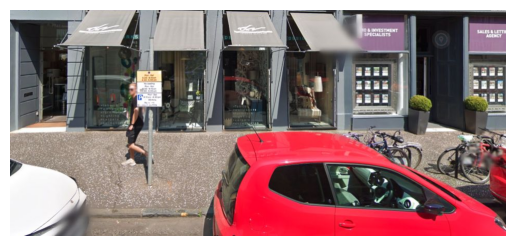

In [ ]:
img = cv2.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Image as a numpy ndarray
input_batch = transform(img).to(device)
plt.imshow(img)
plt.axis('off')

Predict depths and resize to original resolution

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show depth prediction

(437, 958)

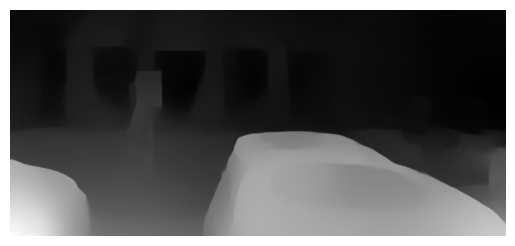

In [ ]:
plt.imshow(output, cmap='gray')
plt.axis('off')
output.shape

# Image segmentation
Set up image segmentation

In [ ]:
!pip install transformers
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from matplotlib import cm

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/9.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/432M [00:00<?, ?B/s]

Reshape and normalise depth map (currently redundant)

In [ ]:
output_reshape = np.dstack((output, output, output)) # Convert to image with 3 dimensions
output_reshape = (output_reshape-np.min(output_reshape))/(np.max(output_reshape)-np.min(output_reshape))

Predict image segments

In [ ]:
img_pil = Image.open(url)

inputs = processor(img_pil, return_tensors='pt')

with torch.no_grad():
  outputs = model(**inputs)

prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[img_pil.size[::-1]])[0]

`label_ids_to_fuse` unset. No instance will be fused.


Display image segments

<ipython-input-145-48b15c2a5c09>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


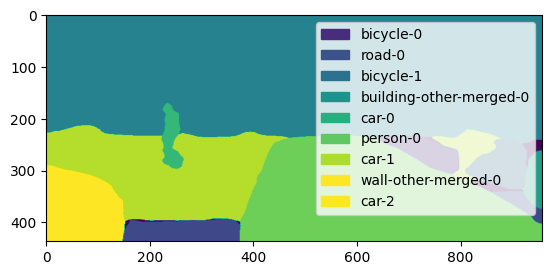

In [ ]:
from collections import defaultdict
import matplotlib.patches as mpatches

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles)
draw_panoptic_segmentation(prediction['segmentation'], prediction['segments_info'])

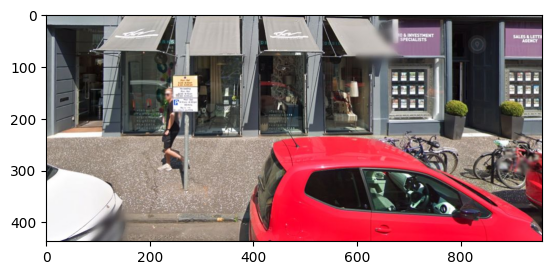

In [ ]:
plt.imshow(img)

Remove segments that are part of background

In [ ]:
# Get the image pils of each segment
images = []
for segment in segments_info:
  segment_image =


# Determine its size in relation to entire image
# If its too big it's likely to be a background image
# Refuse the object if it is

SyntaxError: ignored

Take each segment and create a mask

In [ ]:
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mask2Former/Inference_with_Mask2Former.ipynb

def get_mask(segment_id):
  mask = (prediction['segmentation'].numpy() == segment_id)
  mask = (mask * 255).astype(np.uint8)
  return mask

In [ ]:
"""
def mask_generator():
    for segment_info in prediction['segments_info']:
        mask_pil = get_mask(segment_info['id'])
        mask_pil = Image.fromarray(mask_pil)
        mask_pil = mask_pil.convert('RGB')
        mask_pil = mask_pil.convert('L')
        depth = np.median(output[np.array(mask_pil)]) # To solve - better average depth calculation
        yield mask_pil, depth
"""

def get_depth(mask):
  return np.median(output[np.array(mask)])

In [ ]:
from google.colab.patches import cv2_imshow

Get the width of each segment to decide whether or not its a background image

In [ ]:
def get_width(mask):
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  total_w = 0
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    total_w += w

  return(total_w)

"""
  This method is not effective, the car would be too large and the pavement has been identified as a car
  ADD TO TIMELOG
  1HR - continued working on background object detection
  Need to research foreground detection
"""

Populate using list with details

In [ ]:
mask_info = []
for segment_info in prediction['segments_info']:
  m = get_mask(segment_info['id'])
  if get_width(m) < 0.5*img_pil.width: # 0.5 is an arbitrary number, decide what number to use
    mask_info.append([m, get_depth(m)])

In [ ]:
def display_images(images, size=(50, 10)):
  fig, axes = plt.subplots(1, len(images), figsize=size)

  # Iterate through the images and display them
  for i, plane in enumerate(images):
      axes[i].imshow(plane)
      axes[i].axis('off')

  plt.show()

Sort the list by depth ascending

In [ ]:
mask_info = sorted(mask_info, key=lambda x: x[1])
print("Median depths of segments in ascending order")
for mask in mask_info:
  print(mask[1])

Average depths of segments in ascending order
7.984064


Display the masks and calculate the depths at which to chop the images into

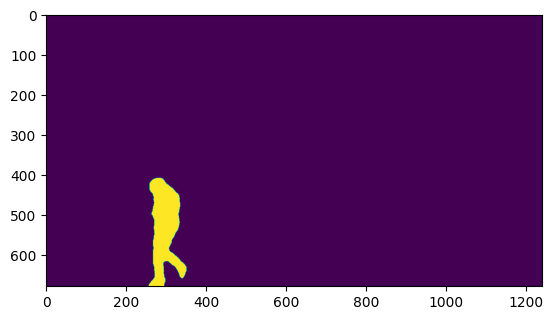

In [ ]:
if len(mask_info) > 1:
  display_images([mask[0] for mask in mask_info])
  depth_ranges = [[mask_info[i][1], mask_info[i+1][1]] for i in range(len(mask_info)-1)]
  print(depth_ranges)
else:
  plt.imshow(mask_info[0][0])
  depth_ranges = 0

Chop the image into different depth levels

In [ ]:
def get_depth_planes(depth_ranges):
  if depth_ranges == 0: # If there are multiple depths
    mask_reshape = np.stack((mask_info[0][0], mask_info[0][0], mask_info[0][0]), axis=-1)
    return np.where(mask_reshape, img, mask_reshape)
  else:
    depth_planes = []
    for (a,b) in depth_ranges:
      for mask in mask_info:
        if a <= mask[1] <= b:
          mask_reshape = np.stack((mask[0], mask[0], mask[0]), axis=-1)
          depth_planes.append(np.where(mask_reshape, img, mask_reshape))
    print("There are " + str(len(depth_planes)) + " depth planes" )
    depth_planes.reverse()
    return depth_planes



(Temporary solution) remove duplicate planes

In [ ]:
def get_unique_planes(depth_planes):
  unique_planes = []

  for plane in depth_planes:
    if not any(np.array_equal(plane, unique) for unique in unique_planes):
      unique_planes.append(plane)
  print(str(len(unique_planes)) + " unique depth planes")
  return unique_planes

Display the different depth planes

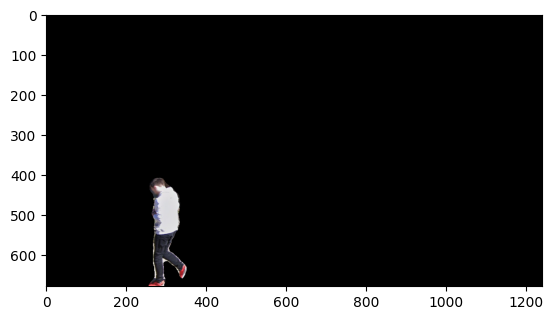

In [ ]:
depth_planes = get_depth_planes(depth_ranges)
if len(mask_info) > 1:
  depth_planes = get_unique_planes(depth_planes)
  display_images(depth_planes)
else:
  plt.imshow(depth_planes)

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

In [ ]:
import inspect
from typing import List, Optional, Union

import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

text_encoder/model.safetensors not found


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


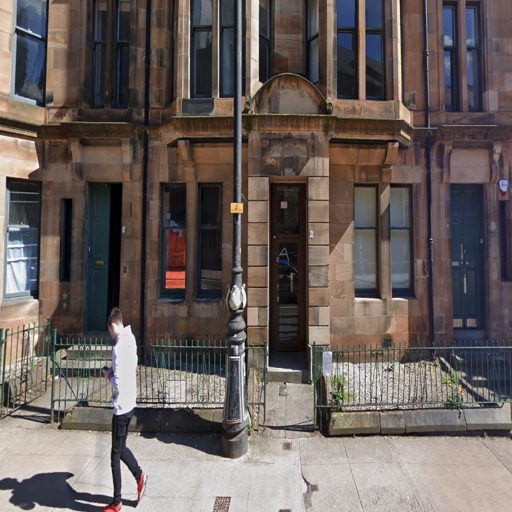

In [ ]:
inpaint_img = img_pil.resize((512, 512))
inpaint_img

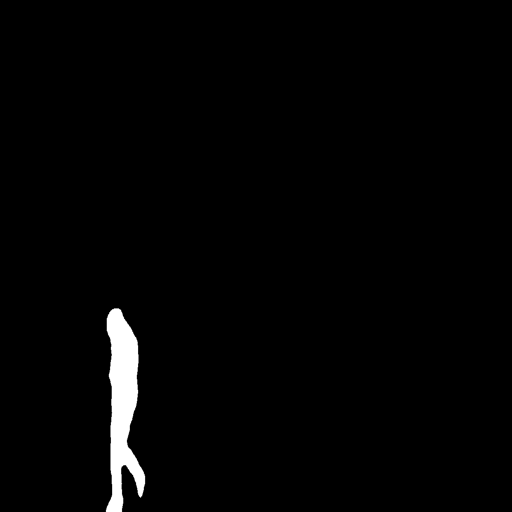

In [ ]:
mask_image = mask_info[3][0].resize((512, 512))
mask_image

In [ ]:
prompt = "Remove person"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=inpaint_img,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# insert initial image in the list so we can compare side by side
images.insert(0, inpaint_img)

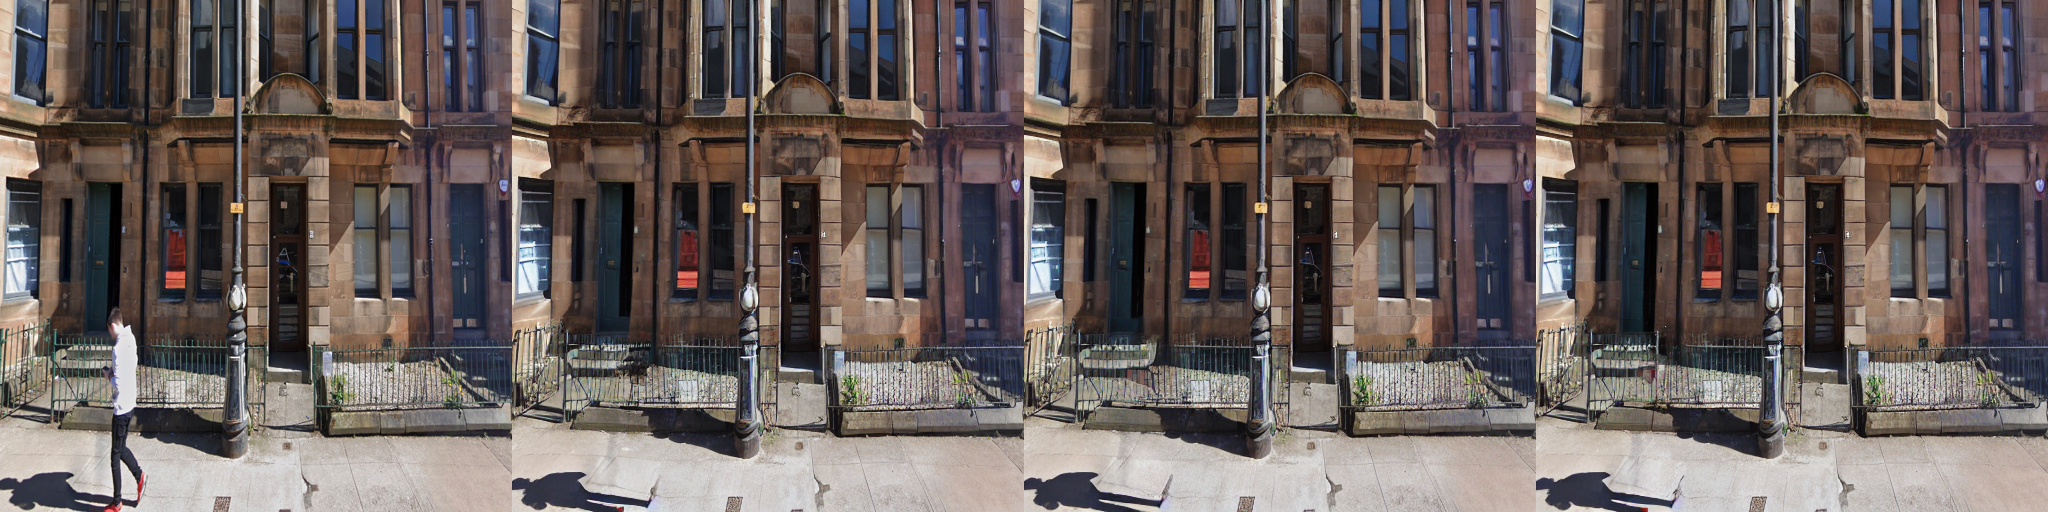

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(images, 1, num_samples + 1)

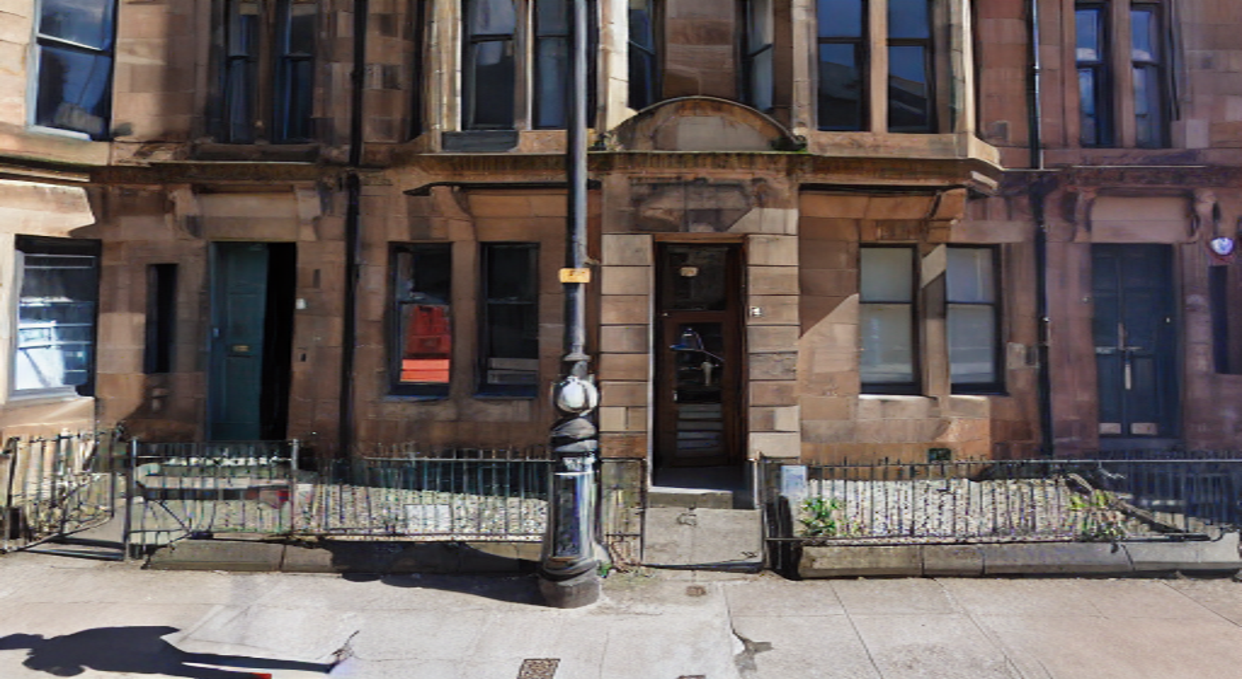

In [ ]:
images[3].resize(img_pil.size)

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

SyntaxError: ignored

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}